In [29]:
import torch
from flamingo_mini import FlamingoModel, FlamingoConfig, FlamingoProcessor
from flamingo_mini.utils import load_url
from einops import repeat


In [30]:
def multimodal_prompt(model: FlamingoModel, processor: FlamingoProcessor, prompt: str, images: list, device: torch.device) -> str:
    """few-shot multimodal prompting 
    
    shape for visual_features parameter: [b=batch size, N=number of images, T=1 (number of frames), v=number of visual features, d=dimensionality of visual feature]
    (I haven't checked if it works with videos)
    """
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)

    pixels = processor(images, device=device)['pixel_values']
    pixels = repeat(pixels, 'N c h w -> b N T c h w', b=1, T=1)
    
    output = model.generate(
        inputs=input_ids,
        media_locations=media_locations,
        attention_mask=attention_mask,
        pixel_values=pixels,
        max_length=150,
        use_cache=True,
        early_stopping=True,
        bos_token_id=model.flamingo.lm.config.bos_token_id,
        eos_token_id=model.flamingo.lm.config.eos_token_id,
        pad_token_id=model.flamingo.lm.config.eos_token_id
    )

    response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
    return response[0]

In [36]:
model = FlamingoModel.from_pretrained('flamingo-VQA-clip-gpt2/checkpoint-144000')

FlamingoConfig {
  "_name_or_path": "flamingo-VQA-clip-gpt2/checkpoint-144000",
  "architectures": [
    "FlamingoModel"
  ],
  "clip_model_type": "Idan0405/ClipMD",
  "dim": 768,
  "dim_visual": 768,
  "freeze_language_model": false,
  "freeze_vision_model": false,
  "lm": "gpt2",
  "resampler_act": "sqrelu",
  "resampler_depth": 6,
  "resampler_dim_head": 64,
  "resampler_ff_mult": 4,
  "resampler_heads": 8,
  "resampler_num_latents": 64,
  "resampler_num_time_embeds": 4,
  "torch_dtype": "float32",
  "transformers_version": "4.28.1",
  "xattn_act": "sqrelu",
  "xattn_dim_head": 64,
  "xattn_every": 1,
  "xattn_ff_mult": 4,
  "xattn_heads": 8
}



In [37]:
device = torch.device('cpu')

In [38]:
model.to(device)
model.eval()

FlamingoModel(
  (flamingo): FlamingoGPT2(
    (vision_encoder): CLIPVisionModel(
      (vision_model): CLIPVisionTransformer(
        (embeddings): CLIPVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
          (position_embedding): Embedding(50, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): CLIPEncoder(
          (layers): ModuleList(
            (0-11): 12 x CLIPEncoderLayer(
              (self_attn): CLIPAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
                (q_proj): Linear(in_features=768, out_features=768, bias=True)
                (out_proj): Linear(in_features=768, out_features=768, bias=True)
              )
              (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (mlp): CLIPMLP(

In [39]:
processor = FlamingoProcessor(model.config)


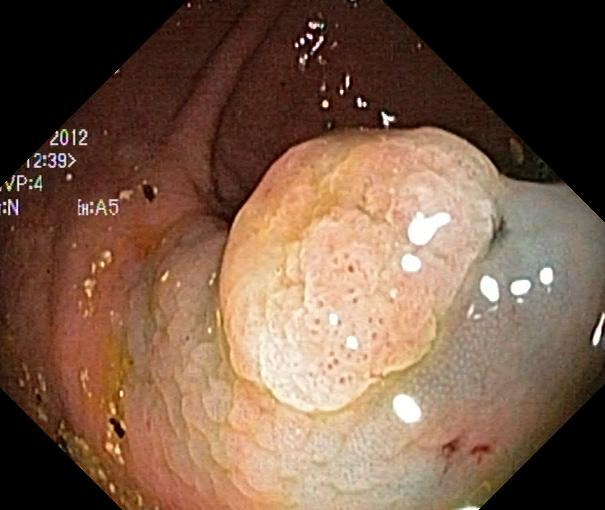

In [54]:
path = "/Users/sookim/flamingo-pytorch/ImageCLEFmed-MEDVQA-GI-2023-Development-Dataset/images"
name = path+"/cl8k2u1pn1dwz0832dxf2cxb5.jpg"
from PIL import Image
img = Image.open(name)
img

In [55]:
prompt = "<image>Question:What color is the anatomical landmark? AnswerType: Text Answer: "
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])


prompt: <image>Question:What color is the anatomical landmark? AnswerType: Text Answer: 
output: <image>Question:What color is the anatomical landmark? AnswerType: Text Answer: iolet<EOC>


In [56]:
prompt = "<image>Question: Where in the image is the anatomical landmark? AnswerType: Text Answer:"
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])

prompt: <image>Question: Where in the image is the anatomical landmark? AnswerType: Text Answer:
output: <image>Question: Where in the image is the anatomical landmark? AnswerType: Text Answer:Not relevant<EOC>


In [57]:
prompt = "<image>Question: Are there any abnormalities in the image AnswerType: Text Answer:"
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])

prompt: <image>Question: Are there any abnormalities in the image AnswerType: Text Answer:
output: <image>Question: Are there any abnormalities in the image AnswerType: Text Answer:Ulcerative colitis<EOC>


In [58]:
prompt = "<image>Question: How many polyps are in the image AnswerType: Number Answer:"
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])

prompt: <image>Question: How many polyps are in the image AnswerType: Number Answer:
output: <image>Question: How many polyps are in the image AnswerType: Number Answer:0<EOC>


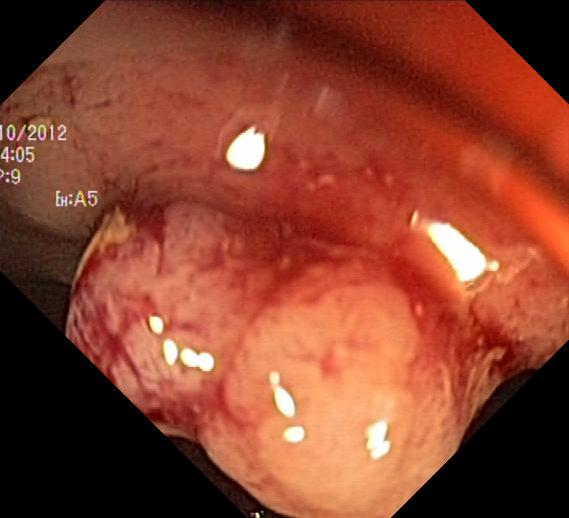

In [59]:
name = path+"/cl8k2u1po1dxn08328vz50fyd.jpg"
img = Image.open(name)
img

In [62]:
prompt = "<image>Question: Are there any abnormalities in the image AnswerType: Text Answer:"
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])

prompt: <image>Question: Are there any abnormalities in the image AnswerType: Text Answer:
output: <image>Question: Are there any abnormalities in the image AnswerType: Text Answer:Ulcerative colitis<EOC>


In [63]:
prompt = "<image>Question:What color is the anatomical landmark? AnswerType: Text Answer: "
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])


prompt: <image>Question:What color is the anatomical landmark? AnswerType: Text Answer: 
output: <image>Question:What color is the anatomical landmark? AnswerType: Text Answer: iolet<EOC>


In [64]:
prompt = "<image>Question: Are there any instruments in the image? AnswerType: Text Answer:"
response = multimodal_prompt(model, processor, prompt, images=[img], device=device)
print('prompt:', prompt)
idx = response.index("<EOC>")
print('output:', response[:idx+5])

prompt: <image>Question: Are there any instruments in the image? AnswerType: Text Answer:
output: <image>Question: Are there any instruments in the image? AnswerType: Text Answer:Not relevant<EOC>
